## Homework 9 - Time Series

In [421]:
import numpy as np
import pandas as pd
import os
import pylab as pl
%pylab inline

PUIdata = os.getenv('PUIDATA')

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### In this analysis we're working with New York City MTA card swipe data from 600 subway stations across the city. Data for each station is broken out into 23 different transit card types, and represents weekly swipe totals over a total duration of 194 weeks.

In [14]:
# Grab the file from location on github and transfer to PUIdata directory on compute
!curl -O 'https://github.com/fedhere/PUI2016_fb55/blob/master/HW9_fb55/MTA_Fare.npy'
os.system('mv ' + 'MTA_Fare.npy ' + PUIdata)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32437    0 32437    0     0  94402      0 --:--:-- --:--:-- --:--:--  270k


0

In [724]:
# Load the data and double check its shape
mtadata = np.load(PUIdata + "/MTA_Fare.npy")
mtadata.shape

(600, 23, 194)

Data cube axes:
    
1. 600 subway stations
2. Data for 23 card types swiped at each station
3. Number of swipes for each card type across 194 weeks

## Task 1: Event Detection

We're looking for the one time period (week) where there is an extreme drop in ridership.

In [766]:
mtadata = mtadata.astype('float')
mtadata[mtadata==-1] = np.nan

In [767]:
# Collapse the card types by averaging
allcardmean = np.nanmean(mtadata, axis=1)
allcardmean.shape
allstationmean = np.nanmean(cardmean, axis=0)
allstationmean.shape

(194,)

In [768]:
allstationstd = np.nanstd(allstationmean)
allweeksmean = np.nanmean(allstationmean)

# We are defining an extreme event as 3 standard deviations below the mean.
threshold = allweeksmean - 3 * allstationstd
events = allstationmean < threshold
events

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [769]:
np.argwhere(events==True)

array([[126]])

In [770]:
weeks = pd.date_range(start='20100521', end='20140221', freq='W')
weeks[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

This is the week that Hurricane Sandy hit New York.

## Task 2: Trend Identification

Here we collapse the stations (treat data like one big station) by summing. This gives us 23 card type time series over 194 weeks.

In [553]:
stations_sum = np.nansum(mtadata, axis=0)
stations_sum.shape

(23, 194)

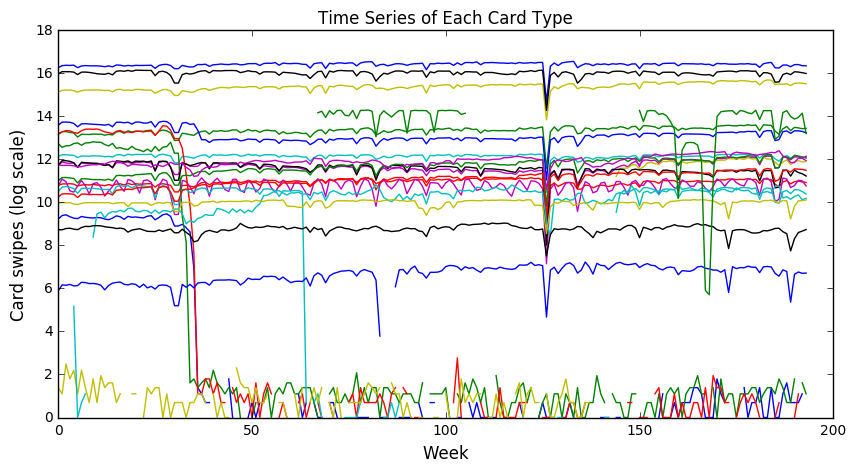

In [554]:
# Plotting each card type to get a sense of the data
pl.figure(figsize=(10,5))
for i in stations_sum:
    pl.plot(log(i)) 
pl.xlabel("Week", fontsize=12)
pl.ylabel("Card swipes (log scale)", fontsize=12)
pl.title('Time Series of Each Card Type')


#### Figure 1: Composite time series of each subway card type ridership.

In [471]:
# Card type names
cardtypes = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [555]:
# Use pandas dataframe to attach card type names to data (and so we can use "rolling" function in next step)
card_data = pd.DataFrame(stations_sum.T, columns=cardtype)
print len(card_data)
card_data.head()

194


10t       14d       1d        2t      30d         7d        ada  \
0  11494615.0  530524.0  47801.0  186551.0  46808.0  3697443.0  8551937.0   
1  12526859.0  583533.0  51486.0  199229.0  64353.0  3981808.0  9486394.0   
2  12766627.0  586194.0  51636.0  199668.0  56994.0  4033030.0  9476538.0   
3  12653675.0  562602.0  52063.0  196389.0  37429.0  4032753.0  9450081.0   
4  12809694.0  548858.0  51153.0  194883.0  35210.0  3925446.0  9294002.0   

      afas       exp        ez  ...      month       rfm       rr      sen  \
0  10063.0  333197.0  512032.0  ...   123134.0  790110.0  59809.0  28221.0   
1  11847.0  282755.0  578023.0  ...   151948.0  908068.0  69209.0  32333.0   
2  12277.0  302028.0  615537.0  ...   151538.0  914124.0  69574.0  32618.0   
3  11221.0  305513.0  606270.0  ...   147094.0  902549.0  68099.0  32404.0   
4  10515.0  335780.0  563446.0  ...   137888.0  855573.0  66377.0  31933.0   

    spec      tcmc        t   umlim   xbus  stud  
0    0.0  124693.0  21060.0  6128.0  358.0   0.0  
1    0.0  121713.0  21670.0  6120.0  474.0   0.0  
2    0.0  122181.0  21433.0  6490.0  465.0   0.0  
3    0.0  122051.0  21630.0  6590.0  484.0   0.0  
4  176.0  119776.0  20297.0  6313.0  452.0   0.0  

[5 rows x 23 columns]

In [592]:
# Calculate the rolling mean using a 10-week window
rolling = card_data.rolling(window=10, center=True).mean()


In [593]:
# This gives us a rolling mean figure for rows 5 through 189 (due to the window we set)
# Now we create an array containing the ratio of the last rolling mean over the first
# The largest value will indicate the greatest positive trend, and the smallest the greates negative trend
# This is assuming that it is a trend and not a structure change to the time series

trend_ratio = np.empty(0,)

rolling = rolling.iloc[5:190,:]
rolling = rolling.reset_index(drop=True)

# The last column/card type is an obvious structural change, so we'll drop that now
rolling = rolling.drop('stud', axis=1)

# Create the array of trend ratios
for i in rolling.columns:
    trend_ratio = np.append(trend_ratio, (rolling[i][184] / rolling[i][0]))

trend_ratio

array([  1.02179793e+00,   1.25206505e+00,   1.11134514e+00,
         9.33803360e-01,   1.03378708e+00,   1.38974760e+00,
         8.99841342e-01,   2.09446969e-04,   1.06870327e-05,
         1.50195580e-06,   8.18802130e-01,   1.21354056e+00,
         2.47849310e+04,   5.78722385e-01,   6.49608431e-01,
         2.59295989e+00,   2.90939677e+00,   7.01823789e+01,
         1.53227106e+00,   1.02158903e+00,   8.09063882e-01,
         1.66232675e+00])

[12 16 17  7  8  9]


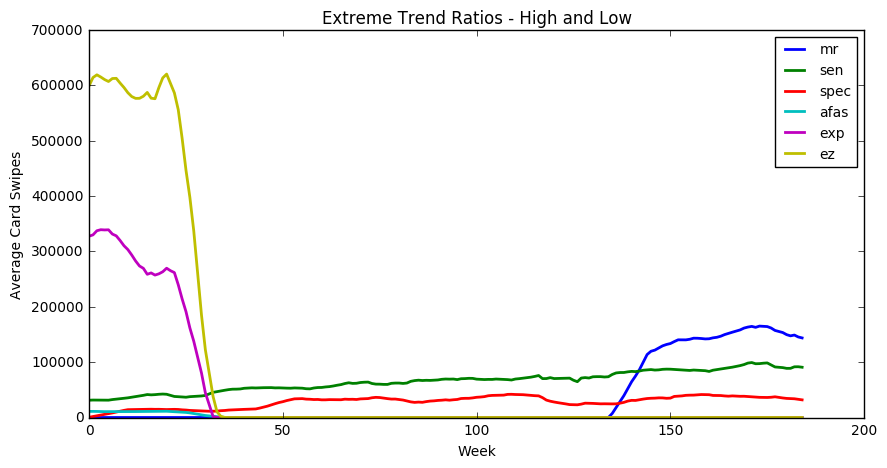

In [591]:
# Let's analyze the 3 largest and 3 smallest ratios visually

# Create an array with indices of largest and smallest values
indices = np.where(trend_ratio > np.sort(trend_ratio)[-4])[0]
indices = np.append(indices, np.where(trend_ratio < np.sort(trend_ratio)[3])[0])
print indices

pl.figure(figsize=(10,5))
for i in indices:
    pl.plot(rolling.iloc[:,i], lw=2)

pl.legend(loc='upper right', fontsize=10)
pl.xlabel('Week')
pl.ylabel('Card swipes')
pl.title('Extreme Trend Ratios - High and Low')

#### Figure 2: Three highest and three lowest trend ratios for card type time series.

It appears that only two of these ratios represent time series with consistent trends throughout the entire duration of the data, i.e. there is no structural change involved. These two are both positive trends (red and green lines above). Some of the time series are at or near zero for most of the weeks, which probably means structural change so we'll get rid of those. Let's try to identify the trend ratios that aren't caused by structural changes in the data.

We could try fitting a line to the different time series and comparing the errors:


In [602]:
import statsmodels.api as sm

x = np.arange(185)

# Compare standard errors for a trend vs structure change
linmodel1 = sm.OLS(rolling['spec'], sm.add_constant(x)).fit()
linmodel2 = sm.OLS(rolling['mr'], sm.add_constant(x)).fit()
print linmodel1.bse[1]
print linmodel2.bse[1]

9.25690939912
54.9027174239


But we can just inspect the time series visually, removing those that show structural change:

In [612]:
rolling_cut = rolling.drop(['afas', 'exp', 'ez', 'mr'], axis=1)
rolling_cut.head()

10t       14d       1d        2t      30d         7d        ada  \
0  12347326.1  533376.2  49898.9  190627.5  47956.2  3934303.6  9117571.2   
1  12438021.8  532186.0  50014.6  190856.4  48741.4  3970926.0  9124481.8   
2  12413400.0  525801.8  49727.9  189699.8  46724.4  3974298.6  9022678.5   
3  12328087.8  516787.3  49310.8  187936.9  43959.0  3966722.6  8915251.8   
4  12301901.5  511925.8  49105.8  186858.1  43932.1  3963185.5  8851225.3   

        ff        mc     month       rfm       rr      sen    spec      tcmc  \
0  41254.9  131889.7  137296.4  844028.3  64516.0  31208.6   454.0  120860.6   
1  41790.3  132944.0  138431.2  846704.1  64826.2  31525.9  1740.9  120940.9   
2  41331.0  131174.8  136185.4  836627.0  64197.5  31426.6  3128.6  121945.7   
3  40723.5  129916.9  133147.9  824119.7  63383.3  31322.8  4197.9  122751.3   
4  40303.7  129063.0  131111.0  815964.5  63007.3  31417.4  5515.0  124538.5   

         t   umlim   xbus  
0  21131.1  6626.3  476.2  
1  21176.8  6756.1  489.8  
2  21167.9  6878.3  489.0  
3  21167.1  6934.6  480.1  
4  21173.3  6963.0  477.8

[11 12 13  9 10 16]


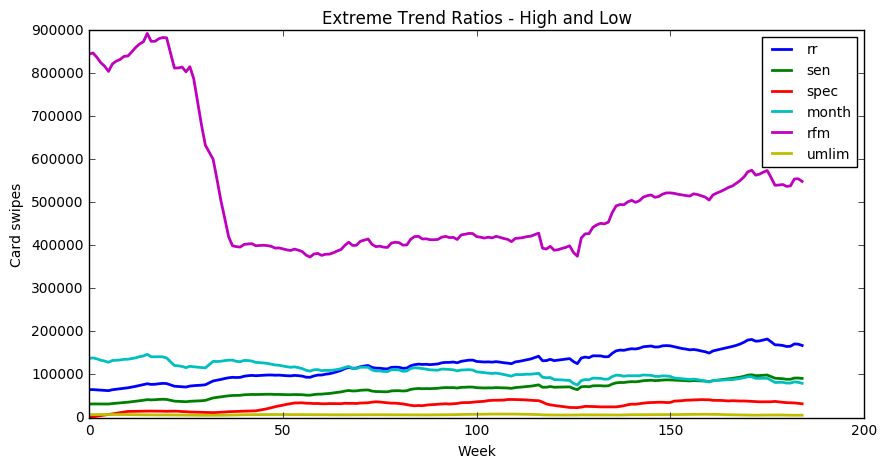

In [613]:
# Repeating the identification of high and low ratios with cut data

trend_ratio_cut = np.empty(0,)

# Create the array of trend ratios
for i in rolling_cut.columns:
    trend_ratio_cut = np.append(trend_ratio_cut, (rolling_cut[i][184] / rolling_cut[i][0]))

# Create an array with indices of largest and smallest values
indices = np.where(trend_ratio_cut > np.sort(trend_ratio_cut)[-4])[0]
indices = np.append(indices, np.where(trend_ratio_cut < np.sort(trend_ratio_cut)[3])[0])
print indices

pl.figure(figsize=(10,5))
for i in indices:
    pl.plot(rolling_cut.iloc[:,i], lw=2)

pl.legend(loc='upper right', fontsize=10)
pl.xlabel('Week')
pl.ylabel('Card swipes')
pl.title('Extreme Trend Ratios - High and Low')

#### Figure 3: Three highest and three lowest trend ratios for card type time series, after removal of time series showing structural change in Figure 2.

Out of these six time series, 'rfm' is the only card type that exhibits structural change.

In [614]:
# We'll drop 'rfm' from the trend ratio array and get the max and min ratios.

rolling_cut = rolling_cut.drop(['rfm'], axis=1)

trend_ratio_cut = np.empty(0,)

for i in rolling_cut.columns:
    trend_ratio_cut = np.append(trend_ratio_cut, (rolling_cut[i][184] / rolling_cut[i][0]))

maxratio = np.sort(trend_ratio_cut)[-1]
minratio = np.sort(trend_ratio_cut)[0]
maxix = np.where(trend_ratio_cut == maxratio)
minix = np.where(trend_ratio_cut == minratio)

print "The card type with the biggest positive trend is " + str(rolling_cut.columns[maxix][0])
print "The card type with the biggest negative trend is " + str(rolling_cut.columns[minix][0])


The card type with the biggest positive trend is spec
The card type with the biggest negative trend is month


## Task 3: Identify Periodicity

Here we are interested in identifying the stations that show a prominent annual periodicity. We will sum the card types for each station to get the total swipes and analyze each station as a whole.

In [615]:
cards_sum = np.nansum(mtadata, axis=1)
cards_sum.shape

(600, 194)

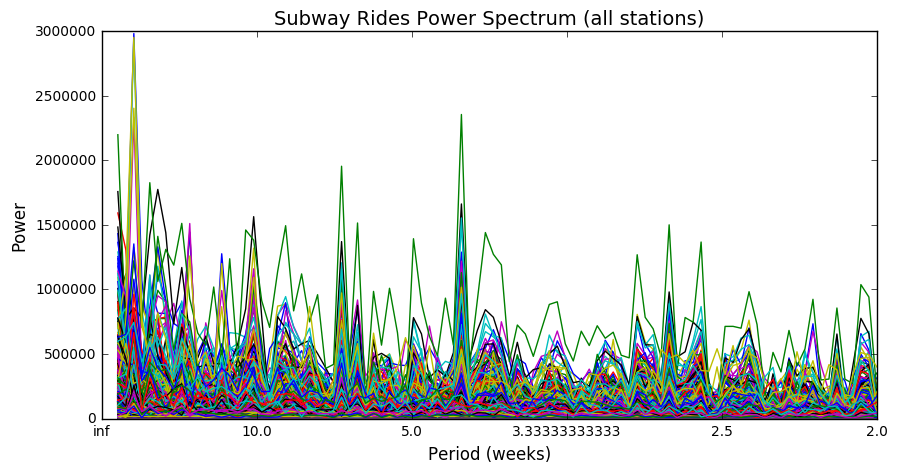

In [641]:
# Plot the power spectrum excluding first 2 frequencies (which are uninteresting because the represent infinity
# and the entire period of the data)
# X axis changed to period (weeks) for readability

fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)

for i in range(len(cards_sum)):
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], np.abs(np.fft.rfft(cards_sum[i])[2:]))

# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, (start + end)/10)) 

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=10)
pl.xlabel("Period (weeks)", fontsize=12)
pl.ylabel("Power", fontsize=12)
pl.title("Subway Rides Power Spectrum (all stations)", fontsize=14)

#### Figure 4: Power spectrum for all stations. Higher power represents stronger periodicity at that number of weeks.

In [771]:
# It looks like are some stations that spike around 52 weeks

In [772]:
f = np.abs(np.fft.rfft(cards_sum))
f.shape

(600, 98)

In [773]:
max_powers = [ i.max() for i in f ]
len(max_powers)

600

In [774]:
np.sort(max_powers)[-4:]

array([  7.63514760e+07,   7.66311260e+07,   7.85456840e+07,
         1.22106744e+08])

In [777]:
max4 = np.sort(max_powers)[-4:]
print "Station indices showing the strongest periodicity:"
for i in max4:
    print np.where(max_powers == i)[0]

Station indices showing the strongest periodicity:
[83]
[45]
[21]
[169]
